## Instalando e Carregando os Pacotes

In [156]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [157]:
# Imports 

# Imports para manipulação e visualização de dados
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Imports para manipulação de imagens
import os
import cv2
import itertools
import shutil
import imageio.v2 as imageio
import skimage
import skimage.io
import skimage.transform
from pathlib import Path

# Imports para Deep Learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.metrics import binary_accuracy

# Imports para cálculo de métricas e outras tarefas
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Definindo o Local de Armazenamento das Imagens de Raio-X

In [158]:
# Lista o conteúdo do diretório
os.listdir('datasets')

['MontgomerySet', 'MCUCXR_0001_0.png', '.DS_Store']

In [159]:
# Diretórios para os 2 grupos de imagens
imagens_mont = 'datasets/MontgomerySet/CXR_png/'

In [160]:
# Print do tamanho de cada pasta
print(len(os.listdir(imagens_mont)))

139


In [161]:
# Grava a lista de imagens em cada pasta
mont_image_list = os.listdir(imagens_mont)

In [162]:
mont_image_list

['MCUCXR_0311_1.png',
 'MCUCXR_0054_0.png',
 'MCUCXR_0051_0.png',
 'MCUCXR_0077_0.png',
 'MCUCXR_0182_1.png',
 'MCUCXR_0023_0.png',
 'MCUCXR_0005_0.png',
 'MCUCXR_0082_0.png',
 'MCUCXR_0068_0.png',
 'MCUCXR_0104_1.png',
 'MCUCXR_0021_0.png',
 'MCUCXR_0362_1.png',
 'MCUCXR_0044_0.png',
 'MCUCXR_0057_0.png',
 'MCUCXR_0015_0.png',
 'MCUCXR_0331_1.png',
 'MCUCXR_0282_1.png',
 'MCUCXR_0042_0.png',
 'MCUCXR_0080_0.png',
 'MCUCXR_0063_0.png',
 'MCUCXR_0006_0.png',
 'MCUCXR_0289_1.png',
 'MCUCXR_0266_1.png',
 'MCUCXR_0016_0.png',
 'MCUCXR_0029_0.png',
 'MCUCXR_0024_0.png',
 'MCUCXR_0258_1.png',
 'MCUCXR_0043_0.png',
 'MCUCXR_0113_1.png',
 'MCUCXR_0369_1.png',
 'MCUCXR_0081_0.png',
 'MCUCXR_0061_0.png',
 'MCUCXR_0019_0.png',
 'MCUCXR_0393_1.png',
 'MCUCXR_0399_1.png',
 'MCUCXR_0083_0.png',
 'MCUCXR_0045_0.png',
 'MCUCXR_0140_1.png',
 'MCUCXR_0100_0.png',
 'MCUCXR_0038_0.png',
 'MCUCXR_0102_0.png',
 'MCUCXR_0092_0.png',
 'MCUCXR_0141_1.png',
 'MCUCXR_0022_0.png',
 'MCUCXR_0162_1.png',
 'MCUCXR_0

## Preparando e Carregando as Imagens de Raio-X

In [163]:
# Prepara os dataframes com as listas das imagens
df_mont = pd.DataFrame(mont_image_list, columns = ['image_id'])

In [164]:
# Visualiza os dados
df_mont.head()

,image_id
0,MCUCXR_0311_1.png
1,MCUCXR_0054_0.png
2,MCUCXR_0051_0.png
3,MCUCXR_0077_0.png
4,MCUCXR_0182_1.png


In [165]:
# Remove da lista o nome 'Thumbs.db'
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

In [166]:
# Reset do índice para reorganizar os índices do dataframe sempre que algo é removido do dataframe
df_mont.reset_index(inplace = True, drop = True)

In [167]:
# Shape
df_mont.shape

(138, 1)

In [168]:
# Visualiza os dados
df_mont.head()

,image_id
0,MCUCXR_0311_1.png
1,MCUCXR_0054_0.png
2,MCUCXR_0051_0.png
3,MCUCXR_0077_0.png
4,MCUCXR_0182_1.png


## Extraindo a Variável Target

In [169]:
# Função para selecionar o índice no final da string (nome do arquivo)
# Exemplo: MCUCXR_0383_1.png --> 1 é o label, significa que Tuberculose está presente na imagem.

def extrair_target(x):
    
    target = int(x[-5])
    
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculose'

In [170]:
# Adicionando label aos dataframe
df_mont['target'] = df_mont['image_id'].apply(extrair_target)

In [171]:
# Visualiza os dados
df_mont.head()

,image_id,target
0,MCUCXR_0311_1.png,Tuberculose
1,MCUCXR_0054_0.png,Normal
2,MCUCXR_0051_0.png,Normal
3,MCUCXR_0077_0.png,Normal
4,MCUCXR_0182_1.png,Tuberculose


In [172]:
# Montgomery Dataset
df_mont['target'].value_counts()

target
Normal         80
Tuberculose    58
Name: count, dtype: int64

## Visualizando as Imagens

In [173]:
# Função para visualizar as imagens
def visualiza_images(col_name, figure_cols, df, caminho_imagens):

    # Define as categorias
    categories = (df.groupby([col_name])[col_name].nunique()).index
    
    # Prepara os subplots
    f, ax = plt.subplots(nrows = len(categories), 
                         ncols = figure_cols, 
                         figsize = (4 * figure_cols, 4 * len(categories))) 
    
    # Desenha as imagens
    for i, cat in enumerate(categories):
        
        # Extrai uma amostra
        sample = df[df[col_name] == cat].sample(figure_cols) 
        
        # Loop pelas colunas da figura
        for j in range(0, figure_cols):
            
            # Extrai o nome da imagem
            file = caminho_imagens + sample.iloc[j]['image_id']
            
            # Lê a imagem do disco
            im = imageio.imread(file)
            
            # Mostra a imagem em gray (preto e branco)
            ax[i, j].imshow(im, resample = True, cmap = 'gray')
            ax[i, j].set_title(cat, fontsize = 14)  
            
    plt.tight_layout()
    plt.show()

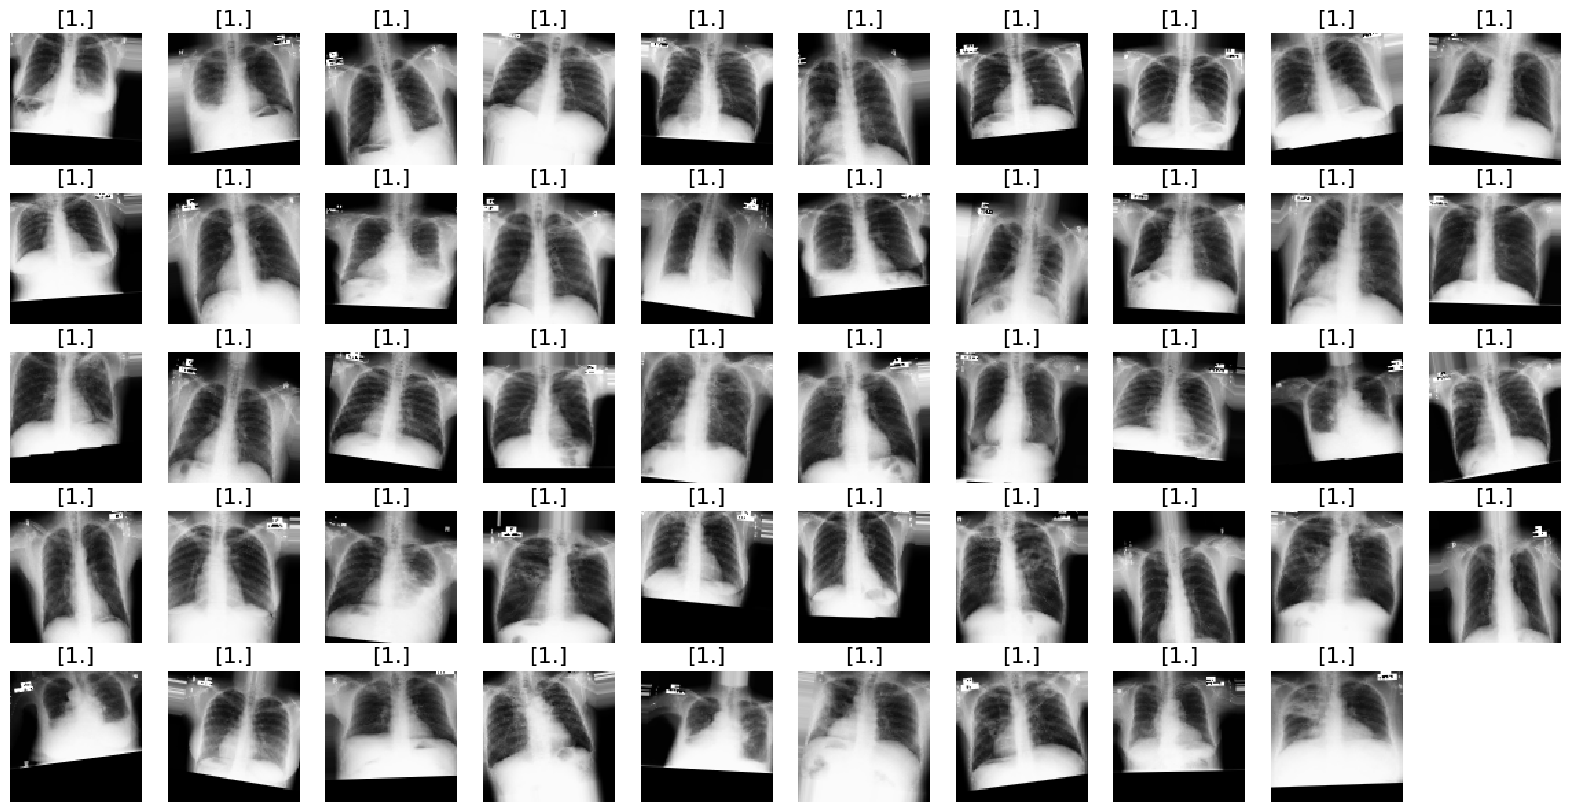

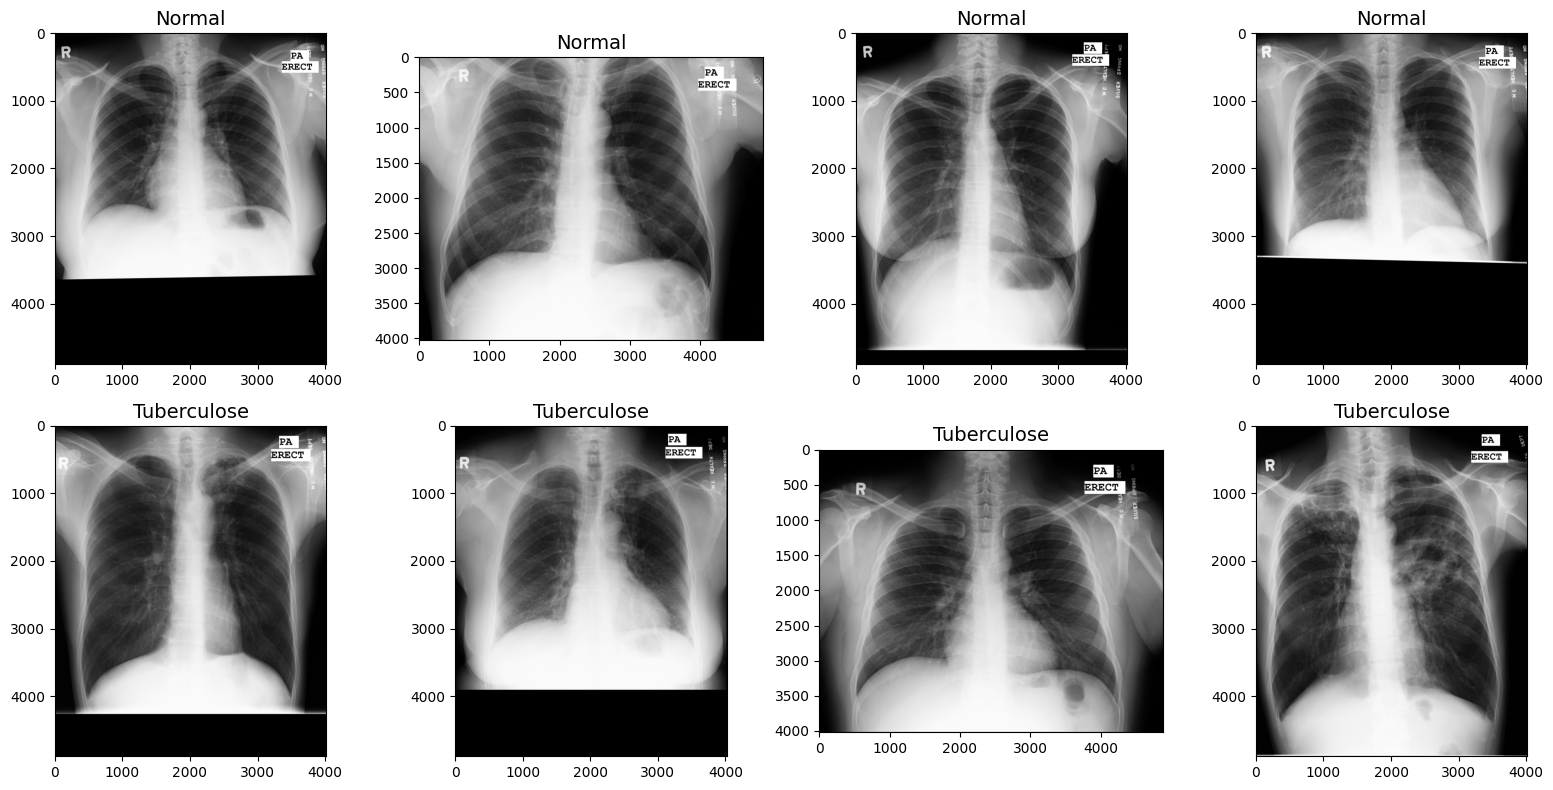

In [174]:
# Montgomery Dataset
visualiza_images('target', 4, df_mont, imagens_mont)

## Ajustando e Organizando o Dataset de Imagens de Raio-X

In [175]:
# Função para leitura dos metadados das imagens
def leitura_imagens(file_name):

    # Leitura da imagem
    image = cv2.imread(caminho_imagens + file_name)
    
    # Extração do número máximo e mínimo de pixels
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[0] - largura da imagem 
    # image.shape[1] - altura da imagem 
    # image.shape[2] - número de canais
    # Se o shape não tiver um valor para num_channels (altura, largura) então atribuímos 1 ao número de canais.
    if len(image.shape) > 2: 
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output

In [176]:
# Define o caminho onde estão as imagens
caminho_imagens = imagens_mont

In [177]:
# Retorna os metadados das imagens
meta_mont = np.stack(df_mont['image_id'].apply(leitura_imagens))

In [178]:
# Grava o resultado em um dataframe
df = pd.DataFrame(meta_mont, columns = ['largura', 'altura', 'canais', 'maior_valor_pixel', 'menor_valor_pixel'])

In [179]:
# Concatena com o dataset atual
df_mont = pd.concat([df_mont, df], axis = 1, sort = False)

In [180]:
# Visualiza
df_mont.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel
0,MCUCXR_0311_1.png,Tuberculose,4892,4020,3,255,0
1,MCUCXR_0054_0.png,Normal,4892,4020,3,255,0
2,MCUCXR_0051_0.png,Normal,4892,4020,3,255,0
3,MCUCXR_0077_0.png,Normal,4020,4892,3,255,0
4,MCUCXR_0182_1.png,Tuberculose,4020,4892,3,255,0


In [181]:
# Não precisamos mais desse dataframe. Removemos para liberar espaço na memória RAM.
del df

## Redimensionamento das Imagens

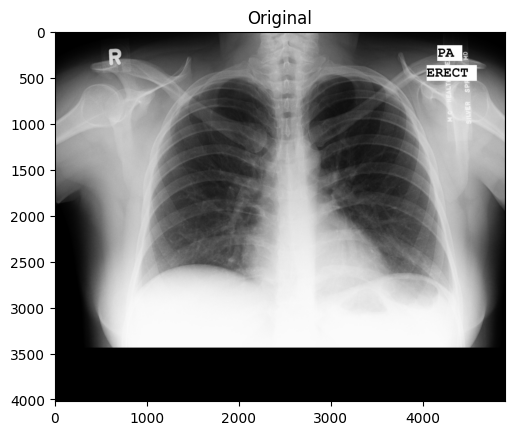

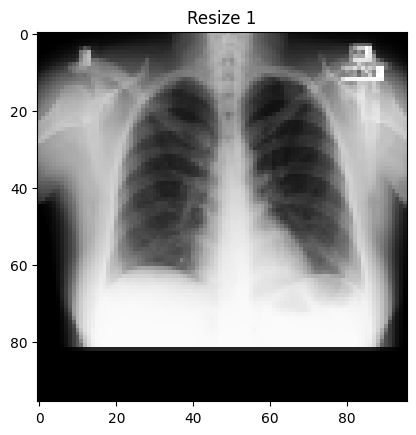

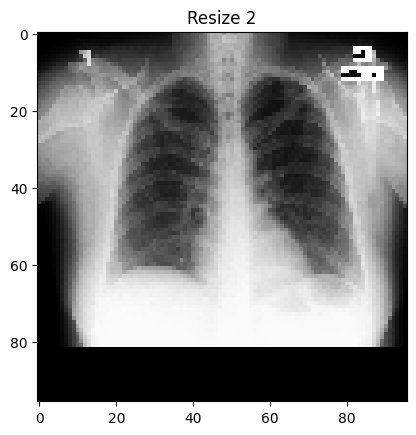

In [182]:
##### Esta célula é apenas um exemplo. #####

# Imports
import cv2 
import numpy as np 
import matplotlib.pyplot as plt  
  
# Imagem original
image1 = cv2.imread("datasets/MCUCXR_0001_0.png") 

# Imagem usando interporlação INTER_AREA
image2 = cv2.resize(image1, (96, 96), interpolation = cv2.INTER_AREA) 
  
# Imagem usando interporlação INTER_LINEAR
image3 = cv2.resize(image1, (96, 96), interpolation = cv2.INTER_LINEAR) 
  
# Plot
plt.title("Original") 
plt.imshow(image1) 
plt.show() 

plt.title("Resize 1") 
plt.imshow(image2) 
plt.show() 

plt.title("Resize 2") 
plt.imshow(image3) 
plt.show() 

## Divisão dos Dados em Treino e Validação

Tarefas que serão realizadas para o treinamento do modelo:

- 1. Concatenar os datasets de imagens
- 2. "Embaralhar" as imagens
- 3. Separar as imagens por classes (Normal / Tuberculose)
- 4. Dividir os dados em treino e validação/teste
- 5. Aplicar as técnicas de processamento de imagens (como redimensionamento) em treino e validação/teste de forma separada

In [183]:
# Total de registros
df_mont['target'].value_counts()

target
Normal         80
Tuberculose    58
Name: count, dtype: int64

In [184]:
# Vamos combinar os dataframes (se tivermos mais de 1)
df_data = df_mont

In [185]:
# E "embaralhar (shuffle)" os dados
df_data = shuffle(df_data)

In [186]:
# Shape
df_data.shape

(138, 7)

In [187]:
# Visualiza os dados
df_data.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel
40,MCUCXR_0102_0.png,Normal,4020,4892,3,255,0
0,MCUCXR_0311_1.png,Tuberculose,4892,4020,3,255,0
128,MCUCXR_0079_0.png,Normal,4020,4892,3,255,0
134,MCUCXR_0056_0.png,Normal,4892,4020,3,255,0
85,MCUCXR_0001_0.png,Normal,4020,4892,3,255,0


In [188]:
# Cria uma nova coluna chamada 'labels' que mapeia as classes para valores binários (0 ou 1)
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculose':1})

In [189]:
# Visualiza os dados
df_data.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel,labels
40,MCUCXR_0102_0.png,Normal,4020,4892,3,255,0,0
0,MCUCXR_0311_1.png,Tuberculose,4892,4020,3,255,0,1
128,MCUCXR_0079_0.png,Normal,4020,4892,3,255,0,0
134,MCUCXR_0056_0.png,Normal,4892,4020,3,255,0,0
85,MCUCXR_0001_0.png,Normal,4020,4892,3,255,0,0


In [190]:
# Definimos y (saída)
y = df_data['labels']

In [191]:
# Definimos dados de treino e validação
df_treino, df_val = train_test_split(df_data, test_size = 0.15, random_state = 101, stratify = y)

In [192]:
# Print
print(df_treino.shape)
print(df_val.shape)

(117, 8)
(21, 8)


In [193]:
# Total de registros
df_treino['target'].value_counts()

target
Normal         68
Tuberculose    49
Name: count, dtype: int64

In [194]:
# Total de registros
df_val['target'].value_counts()

target
Normal         12
Tuberculose     9
Name: count, dtype: int64

## Separando as Imagens Organizadas Por Classe

In [195]:
# Cria um novo diretório que servirá como base
# Você deve alterar o base_dir para o seu diretório
base_dir = 'dados/'

# Criamos o PATH (caminho)
dir_base = Path(base_dir)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_base.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(base_dir)

Criaremos as pastas abaixo no diretório base:

- dados_treino/
    - Normal
    - Tuberculose
    
    
- dados_val/
    - Normal
    - Tuberculose

In [196]:
# Preparamos a criação do diretório com dados de treino
dados_treino = os.path.join(base_dir, 'dados_treino/')

# Criamos o PATH (caminho)
dir_treino = Path(dados_treino)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_treino.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(dados_treino)

In [197]:
# Preparamos a criação do diretório com dados de validação
dados_val = os.path.join(base_dir, 'dados_val/')

# Criamos o PATH (caminho)
dir_val = Path(dados_val)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(dados_val)

In [198]:
# Diretório para imagens de raio-x Normais para treinamento
Normal = os.path.join(dados_treino, 'Normal')

# Criamos o PATH (caminho)
dir_normal_treino = Path(Normal)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_normal_treino.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Normal)

In [199]:
# Diretório com imagens de raio-x com Tuberculose para treinamento
Tuberculose = os.path.join(dados_treino, 'Tuberculose')

# Criamos o PATH (caminho)
dir_tb_treino = Path(Tuberculose)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_tb_treino.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Tuberculose)

In [200]:
# Diretório com imagens de raio-x Normais para validação
Normal = os.path.join(dados_val, 'Normal')

# Criamos o PATH (caminho)
dir_normal_val = Path(Normal)

# Verificamos se o diretório já existe
if dir_normal_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Normal)

In [201]:
# Diretório com imagens de raio-x com Tuberculose para validação
Tuberculose = os.path.join(dados_val, 'Tuberculose')

# Criamos o PATH (caminho)
dir_tb_val = Path(Tuberculose)

# Verificamos se o diretório já existe
if dir_tb_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Tuberculose)

Agora devemos ajustar os índices.

In [202]:
# Define o image_id como o índice em df_data
df_data.set_index('image_id', inplace = True)

In [203]:
# Checamos df_data
df_data.head()

,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel,labels
image_id,,,,,,,
MCUCXR_0102_0.png,Normal,4020,4892,3,255,0,0
MCUCXR_0311_1.png,Tuberculose,4892,4020,3,255,0,1
MCUCXR_0079_0.png,Normal,4020,4892,3,255,0,0
MCUCXR_0056_0.png,Normal,4892,4020,3,255,0,0
MCUCXR_0001_0.png,Normal,4020,4892,3,255,0,0


In [204]:
# Obtém uma lista de imagens em cada uma das duas pastas originais
folder_2 = os.listdir(imagens_mont)

In [205]:
folder_2[1:10]

['MCUCXR_0054_0.png',
 'MCUCXR_0051_0.png',
 'MCUCXR_0077_0.png',
 'MCUCXR_0182_1.png',
 'MCUCXR_0023_0.png',
 'MCUCXR_0005_0.png',
 'MCUCXR_0082_0.png',
 'MCUCXR_0068_0.png',
 'MCUCXR_0104_1.png']

In [206]:
# Obtém uma lista de imagens de treino e validação
lista_imagens_treino = list(df_treino['image_id'])
lista_imagens_val = list(df_val['image_id'])

In [207]:
lista_imagens_treino[20:30]

['MCUCXR_0071_0.png',
 'MCUCXR_0047_0.png',
 'MCUCXR_0195_1.png',
 'MCUCXR_0331_1.png',
 'MCUCXR_0019_0.png',
 'MCUCXR_0060_0.png',
 'MCUCXR_0031_0.png',
 'MCUCXR_0053_0.png',
 'MCUCXR_0026_0.png',
 'MCUCXR_0367_1.png']

In [208]:
lista_imagens_val[10:20]

['MCUCXR_0020_0.png',
 'MCUCXR_0028_0.png',
 'MCUCXR_0022_0.png',
 'MCUCXR_0173_1.png',
 'MCUCXR_0091_0.png',
 'MCUCXR_0048_0.png',
 'MCUCXR_0044_0.png',
 'MCUCXR_0126_1.png',
 'MCUCXR_0255_1.png',
 'MCUCXR_0113_1.png']

## Pré-Processamento das Imagens

In [209]:
# Resize das imagens
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

Agora copiamos as imagens separadas por classe, redimensionamos e organizamos no novo diretório.

In [210]:
# Transfere as imagens de treino pré-processadas para o novo diretório

print('\nPré-processamento dos dados de treino! Aguarde...')

# Loop pela lista de imagens de treino
for image in lista_imagens_treino:
    
    # Nome da imagem
    fname = image
    
    # Label da imagem
    label = df_data.loc[image,'target']

    # Percorremos a folder_2 (imagens do dataset de montgomery) para buscar o caminho da imagem
    if fname in folder_2:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_mont, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_treino, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)

print('\nOs dados de treino estão prontos!')


Pré-processamento dos dados de treino! Aguarde...

Os dados de treino estão prontos!


In [211]:
# Transfere as imagens de validação pré-processadas para o novo diretório

print('\nPré-processamento dos dados de valiação/teste! Aguarde...')

# Loop pela lista de imagens de validação/teste
for image in lista_imagens_val:
    
    # Nome da imagem
    fname = image
    
    # Label da imagem
    label = df_data.loc[image,'target']

    # Percorremos a folder_2 (imagens do dataset de montgomery) para buscar o caminho da imagem
    if fname in folder_2:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_mont, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_val, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)
        
print('\nOs dados de validação/teste estão prontos!')


Pré-processamento dos dados de valiação/teste! Aguarde...

Os dados de validação/teste estão prontos!


In [212]:
# Verificamos quantas imagens de treino temos em cada pasta de classe
print(len(os.listdir(dados_treino + '/Normal')))
print(len(os.listdir(dados_treino + '/Tuberculose')))

68
49


In [213]:
# Verificamos quantas imagens de validação temos em cada pasta de classe
print(len(os.listdir(dados_val + '/Normal')))
print(len(os.listdir(dados_val + '/Tuberculose')))

12
9


## Dataset Augmentation (Geração de Imagens Sintéticas)

Para Deep Learning mostrar seu valor precisamos de um grande volume de dados. E coletar mais dados é um processo demorado e que envolve custo.

Uma alternativa é criar dados sintéticos. Por exemplo: tomamos uma imagem original e aplicamos um flip (giro) de 15 graus na imagem e criamos uma nova imagem. Teremos o mesmo tipo de imagem, mas com uma leve modificação no formato. Essa técnica é chamada de Dataset Augmentation e é amplamente usada em Inteligência Artificial para suprir a carência de dados em volume suficiente.

Criaremos imagens sintéticas, armazenaremos em pastas juntamente com as imagens originais e depois as alimentaremos nos geradores de batches para o treinamento. Trabalhar dessa maneira acelera o processo de treinamento.

In [214]:
# Lista de classes
class_list = ['Normal', 'Tuberculose']

In [215]:
# Número de imagens sintéticas desejadas
NUM_IMAGENS_SINTETICAS = 1000 

In [216]:
# Cria imagens sintéticas para aumentar o volume de dados de treino (não fazemos isso com dados de validação/teste)

print('\nGeração de imagens sintéticas para treinamento! Aguarde...\n')

# Loop pelas imagens de cada classe
for item in class_list:
    
    # Estamos criando diretório temporário aqui porque o excluiremos posteriormente.
    # Criamos um diretório base
    aug_dir = base_dir + 'temp/'
    os.mkdir(aug_dir)
    
    # Criamos um diretório dentro do diretório base para armazenar imagens da mesma classe
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Escolhe a classe
    img_class = item

    # Listamos todas as imagens no diretório
    img_list = os.listdir(dados_treino + img_class)

    # Copiamos imagens do diretório de treino para a classe no loop, para o img_dir
    for fname in img_list:
            
            # Diretório fonte da imagem
            src = os.path.join(dados_treino + img_class, fname)
            
            # Diretório destino da imagem
            dst = os.path.join(img_dir, fname)
            
            # Copia a imagem da fonte para o destino
            shutil.copyfile(src, dst)


    # Apontamos para o diretório contendo as imagens que foram copiadas
    path = aug_dir
    save_path = dados_treino + img_class

    # Criamos um gerador de imagens 
    datagen = ImageDataGenerator(rotation_range = 10,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 zoom_range = 0.1,
                                 horizontal_flip = True,
                                 fill_mode = 'nearest')

    # Tamanho do batch
    batch_size = 50

    # Geração de dados
    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir = save_path,
                                              save_format = 'png',
                                              target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                              batch_size = batch_size)
    
    
    # Geramos as imagens aumentadas e adicionamos às pastas de treinamento
    num_files = len(os.listdir(img_dir))
    
    # Aqui criamos uma quantidade semelhante de imagens para cada classe
    num_batches = int(np.ceil((NUM_IMAGENS_SINTETICAS - num_files) / batch_size))

    # Executa o gerador e cria imagens aumentadas
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)
        
    # Exclui o diretório temporário com os arquivos de imagem brutos
    shutil.rmtree(aug_dir)
    
print('\nOs dados foram criados com sucesso!')


Geração de imagens sintéticas para treinamento! Aguarde...

Found 68 images belonging to 1 classes.
Found 49 images belonging to 1 classes.

Os dados foram criados com sucesso!


In [217]:
# Verificamos quantas imagens de treino temos agora em cada pasta.
# Estas são as imagens originais mais as imagens sintéticas.
print(len(os.listdir(dados_treino + 'Normal')))
print(len(os.listdir(dados_treino + 'Tuberculose')))

730
1029


In [218]:
# Verifica quantas imagens de validação temos em cada pasta (deve ser o mesmo número inicial)
# Estas são as imagens originais mais as imagens sintéticas.
print(len(os.listdir(dados_val + 'Normal')))
print(len(os.listdir(dados_val + 'Tuberculose')))

12
9


Vamos visualizar algumas imagens sintéticas.

In [219]:
# Função para o plot de algumas imagens
def plots(ims, figsize = (20,10), rows = 5, interp = False, titles = None): 
    
    # Obtém a imagem
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    
    # Define o tamanho da figura
    f = plt.figure(figsize = figsize)
    
    # Colunas
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    
    # Plot
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

In [220]:
# Executa a função
plots(imgs, titles = labels) 

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Definindo Amostras e Batches de Dados Para Treinamento e Teste

In [221]:
# Número de exemplos de treinamento
num_amostras_treino = len(df_treino)

In [222]:
# Tamanho do batch de treino
batch_size_treino = 4

In [223]:
# Número de exemplos de validação
num_amostras_val = len(df_val)

In [224]:
# Tamanho do batch de validação
batch_size_val = 4

In [225]:
# Aqui definimos o número de passos
passos_treino = int(np.ceil(num_amostras_treino // batch_size_treino))
passos_val = int(np.ceil(num_amostras_val // batch_size_val))

Geramos os batches de dados para treino, validação e teste. Usaremos as mesmas imagens para avaliar o modelo durante o treino (validação) e depois do treino (teste).

In [226]:
# Aqui geramos os batches de dados
datagen = ImageDataGenerator(rescale = 1.0/255)

# Gera os batches de treino
gen_treino = datagen.flow_from_directory(dados_treino,
                                         target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                         batch_size = batch_size_treino,
                                         class_mode = 'categorical')

# Gera os batches de validação
gen_val = datagen.flow_from_directory(dados_val,
                                      target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                      batch_size = batch_size_val,
                                      class_mode = 'categorical')

# Gera os batches de teste
# Nota: shuffle = False faz com que o conjunto de dados de teste não seja "embaralhado"
gen_teste = datagen.flow_from_directory(dados_val,
                                        target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                        batch_size = batch_size_val,
                                        class_mode = 'categorical',
                                        shuffle = False)

Found 1759 images belonging to 2 classes.
Found 21 images belonging to 2 classes.
Found 21 images belonging to 2 classes.


Podemos agora construir o modelo.

## Construção do Modelo de Inteligência Artificial

In [227]:
# Tamanho do kernel
kernel_size = (3,3)

# Tamanho do Pool
pool_size = (2,2)

# Número de neurônios da primeira camada
num_neurons_1 = 32

# Número de neurônios da primeira camada
num_neurons_2 = 64

# Número de neurônios da primeira camada
num_neurons_3 = 128

# Taxa de dropout nas camadas de convolução
dropout_conv = 0.3

# Taxa de dropout na camada densa
dropout_dense = 0.3

# Taxa de aprendizado
taxa_aprendizado = 0.0001

# Número de épocas de treinamento
num_epochs = 300

In [228]:
# Cria a sequência de camadas
modelo_dsa = Sequential()

In [229]:
# Adicionamos a primeira camada convolucional com 3 operações de convolução
modelo_dsa.add(Conv2D(num_neurons_1, kernel_size, activation = 'relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
modelo_dsa.add(Conv2D(num_neurons_1, kernel_size, activation = 'relu'))
modelo_dsa.add(Conv2D(num_neurons_1, kernel_size, activation = 'relu'))
modelo_dsa.add(MaxPooling2D(pool_size = pool_size)) 
modelo_dsa.add(Dropout(dropout_conv))

In [230]:
# Adicionamos a segunda camada convolucional com 3 operações de convolução
modelo_dsa.add(Conv2D(num_neurons_2, kernel_size, activation = 'relu'))
modelo_dsa.add(Conv2D(num_neurons_2, kernel_size, activation = 'relu'))
modelo_dsa.add(Conv2D(num_neurons_2, kernel_size, activation = 'relu'))
modelo_dsa.add(MaxPooling2D(pool_size = pool_size))
modelo_dsa.add(Dropout(dropout_conv))

In [231]:
# Adicionamos a terceira camada convolucional com 3 operações de convolução
modelo_dsa.add(Conv2D(num_neurons_3, kernel_size, activation = 'relu'))
modelo_dsa.add(Conv2D(num_neurons_3, kernel_size, activation = 'relu'))
modelo_dsa.add(Conv2D(num_neurons_3, kernel_size, activation = 'relu'))
modelo_dsa.add(MaxPooling2D(pool_size = pool_size))
modelo_dsa.add(Dropout(dropout_conv))

In [232]:
# Camada de "achatamento"
modelo_dsa.add(Flatten())

In [233]:
# Camada densa com dropout
modelo_dsa.add(Dense(256, activation = "relu"))
modelo_dsa.add(Dropout(dropout_dense))

In [234]:
# Camada de saída
modelo_dsa.add(Dense(2, activation = "softmax"))

In [235]:
# Sumário do modelo
modelo_dsa.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 252, 252, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 250, 250, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 123, 123, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 121, 121, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 119, 119, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 57, 57, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 55, 55, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 53, 53, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,632,706 (86.34 MB)

 Trainable params: 22,632,706 (86.34 MB)

 Non-trainable params: 0 (0.00 B)

Teremos mais de 1 milhão e meio de parâmetros para treinar. 

Precisamos agora compilar o modelo, quando definimos o algoritmo de treinamento (Adam em nosso caso, pois apresenta ótima performance com imagens), a função de custo (binary_crossentropy é normalmente usada para classificação binária) e a métrica que será usada no treinamento (acurácia em nosso caso).

O otimizador Adam (Adaptive Moment Estimation) é um método de otimização utilizado em redes neurais e em outras aplicações de aprendizado de máquina para atualizar os pesos da rede de forma eficiente. Ele é conhecido por ser particularmente eficaz em casos com grandes conjuntos de dados e/ou parâmetros de modelo em grande escala. O Adam combina aspectos de outros métodos de otimização, como a Descida de Gradiente com Momento e a RMSprop, e apresenta várias características-chave:

**Taxas de Aprendizado Adaptativas**: Diferentemente de métodos como a descida de gradiente estocástica (SGD) que utiliza uma taxa de aprendizado fixa, o Adam ajusta a taxa de aprendizado de cada parâmetro individualmente com base em estimativas de momentos de primeira e segunda ordem (daí o nome "Adaptive Moment Estimation").

**Cálculo de Momentos**: O Adam mantém duas médias móveis para cada parâmetro - uma para os gradientes (momentos de primeira ordem) e outra para o quadrado dos gradientes (momentos de segunda ordem). Essas médias são usadas para calcular as taxas de aprendizado adaptativas.

**Correção de Viés Inicial**: Nos estágios iniciais do treinamento, as médias móveis estão fortemente inclinadas em direção a zero, levando a estimativas enviesadas. O Adam implementa uma correção de viés para essas estimativas, tornando-as mais precisas.

**Eficiência Computacional**: O Adam é computacionalmente eficiente, requerendo uma quantidade de memória relativamente pequena. Além disso, ele é invariante à reescala diagonal dos gradientes, e é bem adequado para problemas que são grandes em termos de dados e/ou parâmetros.

**Aplicabilidade Ampa**: Devido à sua robustez e eficiência, o Adam é frequentemente usado em uma ampla gama de aplicações de aprendizado de máquina, desde redes neurais convolucionais até redes neurais recorrentes.

Por causa dessas características, o Adam se tornou um dos otimizadores mais populares no campo do aprendizado de máquina e é frequentemente a escolha padrão para muitas aplicações de aprendizado profundo.

In [236]:
# Compilação do modelo
modelo_dsa.compile(tf.keras.optimizers.Adam(taxa_aprendizado), 
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

In [237]:
# Criamos um diretório para salvar o modelo treinado
modelos_base_dir = '.'
modelos_dir = os.path.join(modelos_base_dir, 'modelos/')

In [238]:
# Define o Path
dir_modelos = Path(modelos_dir)

In [239]:
# Cria, se não existir
if dir_modelos.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(modelos_dir)

In [240]:
# Nome completo do modelo a ser salvo
modelo_salvo = modelos_dir + 'modelo_dsa_p1.keras'

In [241]:
# Definimos um checkpoint para verificar regularmente se a acurácia em validação melhorou
# Se a performance melhorar em validação salvamos o modelo
# Podemos ainda optar por salvar o modelo a cada número de épocas
checkpoint = ModelCheckpoint(modelo_salvo, 
                             monitor = 'val_accuracy', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'max')

Uma boa estratégia é reduzir a taxa de aprendizado de forma gradativa, sempre que o modelo parar de aprender. O ReduceLROnPlateau é uma estratégia de otimização em treinamento de redes neurais, onde a taxa de aprendizado é reduzida quando uma métrica de desempenho para de melhorar. 

Essencialmente, esta técnica ajusta a taxa de aprendizado durante o treinamento ao observar a evolução do desempenho do modelo e reduzindo a taxa de aprendizado quando o treinamento parece estagnar ou progredir muito lentamente.

In [242]:
# Redução gradual da taxa de aprendizado (Reduce on Plateau)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.5, 
                              patience = 2, 
                              verbose = 1, 
                              mode = 'max', 
                              min_lr = 0.00001)

In [243]:
# Cria os callbacks que serão usados no treinamento
callbacks_list = [checkpoint, reduce_lr]

## Treinamento do Modelo

In [244]:
%%time
history = modelo_dsa.fit(gen_treino, 
                         steps_per_epoch = (passos_treino), 
                         validation_data = gen_val,
                         validation_steps = (passos_val),
                         epochs = num_epochs, 
                         verbose = 1,
                         callbacks = callbacks_list)

Epoch 1/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.5700 - loss: 0.7452 
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to ./modelos/modelo_dsa_p1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 559ms/step - accuracy: 0.5686 - loss: 0.7443 - val_accuracy: 0.4000 - val_loss: 0.6953 - learning_rate: 1.0000e-04
Epoch 2/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.6322 - loss: 0.6818 
Epoch 2: val_accuracy improved from 0.40000 to 0.45000, saving model to ./modelos/modelo_dsa_p1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 568ms/step - accuracy: 0.6309 - loss: 0.6822 - val_accuracy: 0.4500 - val_loss: 0.6959 - learning_rate: 1.0000e-04
Epoch 3/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.5946 - loss: 0.6814 
Epoch 3: val_accuracy did not improve from 0.45000
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 534ms/step - accuracy: 0.5946 - loss: 0.6814 - val_accuracy: 0.4500 - val_loss: 0.6994 - learning_rate: 1.0000e-04
Epoch 4/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 517m

Epoch 84/300
12/12 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.5667
Epoch 84: val_accuracy did not improve from 0.42857
12/12 [==============================] - 1s 78ms/step - loss: 0.6749 - accuracy: 0.5667 - val_loss: 0.7113 - val_accuracy: 0.4286 - lr: 1.0000e-05
Epoch 85/300
12/12 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5417
Epoch 85: val_accuracy improved from 0.42857 to 0.47619, saving model to ./modelos/modelo_dsa_p1.keras
12/12 [==============================] - 1s 79ms/step - loss: 0.6916 - accuracy: 0.5417 - val_loss: 0.7027 - val_accuracy: 0.4762 - lr: 1.0000e-05
Epoch 86/300
12/12 [==============================] - ETA: 0s - loss: 0.6625 - accuracy: 0.6303
Epoch 86: val_accuracy did not improve from 0.47619
12/12 [==============================] - 1s 76ms/step - loss: 0.6625 - accuracy: 0.6303 - val_loss: 0.7029 - val_accuracy: 0.4762 - lr: 1.0000e-05
Epoch 87/300
12/12 [==============================] - ETA: 0s - 

Epoch 112/300
12/12 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.6250
Epoch 112: val_accuracy did not improve from 0.47619
12/12 [==============================] - 1s 74ms/step - loss: 0.6502 - accuracy: 0.6250 - val_loss: 0.7145 - val_accuracy: 0.4286 - lr: 1.0000e-05
Epoch 113/300
12/12 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.6417
Epoch 113: val_accuracy did not improve from 0.47619
12/12 [==============================] - 1s 73ms/step - loss: 0.6402 - accuracy: 0.6417 - val_loss: 0.7136 - val_accuracy: 0.4286 - lr: 1.0000e-05
Epoch 114/300
12/12 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.6750
Epoch 114: val_accuracy did not improve from 0.47619
12/12 [==============================] - 1s 76ms/step - loss: 0.6304 - accuracy: 0.6750 - val_loss: 0.7204 - val_accuracy: 0.4286 - lr: 1.0000e-05
Epoch 115/300
12/12 [==============================] - ETA: 0s - loss: 0.6481 - accuracy: 0.6750
Epoch 115: v

Epoch 140/300
12/12 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.5917
Epoch 140: val_accuracy did not improve from 0.47619
12/12 [==============================] - 1s 79ms/step - loss: 0.6804 - accuracy: 0.5917 - val_loss: 0.6933 - val_accuracy: 0.4286 - lr: 1.0000e-05
Epoch 141/300
12/12 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.6000
Epoch 141: val_accuracy improved from 0.47619 to 0.52381, saving model to ./modelos/modelo_dsa_p1.keras
12/12 [==============================] - 1s 78ms/step - loss: 0.6669 - accuracy: 0.6000 - val_loss: 0.6855 - val_accuracy: 0.5238 - lr: 1.0000e-05
Epoch 142/300
12/12 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5333
Epoch 142: val_accuracy did not improve from 0.52381
12/12 [==============================] - 1s 78ms/step - loss: 0.6925 - accuracy: 0.5333 - val_loss: 0.6893 - val_accuracy: 0.5238 - lr: 1.0000e-05
Epoch 143/300
12/12 [==============================] - ETA

12/12 [==============================] - 1s 77ms/step - loss: 0.6539 - accuracy: 0.6250 - val_loss: 0.7027 - val_accuracy: 0.4286 - lr: 1.0000e-05
Epoch 168/300
12/12 [==============================] - ETA: 0s - loss: 0.6589 - accuracy: 0.6417
Epoch 168: val_accuracy did not improve from 0.52381
12/12 [==============================] - 1s 78ms/step - loss: 0.6589 - accuracy: 0.6417 - val_loss: 0.6847 - val_accuracy: 0.5238 - lr: 1.0000e-05
Epoch 169/300
12/12 [==============================] - ETA: 0s - loss: 0.5855 - accuracy: 0.7083
Epoch 169: val_accuracy did not improve from 0.52381
12/12 [==============================] - 1s 78ms/step - loss: 0.5855 - accuracy: 0.7083 - val_loss: 0.6866 - val_accuracy: 0.5238 - lr: 1.0000e-05
Epoch 170/300
12/12 [==============================] - ETA: 0s - loss: 0.6514 - accuracy: 0.6083
Epoch 170: val_accuracy did not improve from 0.52381
12/12 [==============================] - 1s 77ms/step - loss: 0.6514 - accuracy: 0.6083 - val_loss: 0.6985 - 

Epoch 195/300
12/12 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.6833
Epoch 195: val_accuracy did not improve from 0.57143
12/12 [==============================] - 1s 78ms/step - loss: 0.6092 - accuracy: 0.6833 - val_loss: 0.6970 - val_accuracy: 0.4762 - lr: 1.0000e-05
Epoch 196/300
12/12 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.6250
Epoch 196: val_accuracy did not improve from 0.57143
12/12 [==============================] - 1s 77ms/step - loss: 0.6698 - accuracy: 0.6250 - val_loss: 0.6885 - val_accuracy: 0.5714 - lr: 1.0000e-05
Epoch 197/300
12/12 [==============================] - ETA: 0s - loss: 0.5943 - accuracy: 0.7250
Epoch 197: val_accuracy did not improve from 0.57143
12/12 [==============================] - 1s 79ms/step - loss: 0.5943 - accuracy: 0.7250 - val_loss: 0.6821 - val_accuracy: 0.5714 - lr: 1.0000e-05
Epoch 198/300
12/12 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.7083
Epoch 198: v

Epoch 223/300
12/12 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.7250
Epoch 223: val_accuracy did not improve from 0.57143
12/12 [==============================] - 1s 78ms/step - loss: 0.5813 - accuracy: 0.7250 - val_loss: 0.6918 - val_accuracy: 0.5714 - lr: 1.0000e-05
Epoch 224/300
12/12 [==============================] - ETA: 0s - loss: 0.6281 - accuracy: 0.6250
Epoch 224: val_accuracy did not improve from 0.57143
12/12 [==============================] - 1s 76ms/step - loss: 0.6281 - accuracy: 0.6250 - val_loss: 0.6901 - val_accuracy: 0.5238 - lr: 1.0000e-05
Epoch 225/300
12/12 [==============================] - ETA: 0s - loss: 0.6210 - accuracy: 0.6833
Epoch 225: val_accuracy did not improve from 0.57143
12/12 [==============================] - 1s 80ms/step - loss: 0.6210 - accuracy: 0.6833 - val_loss: 0.6797 - val_accuracy: 0.5714 - lr: 1.0000e-05
Epoch 226/300
12/12 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.6917
Epoch 226: v

12/12 [==============================] - 1s 78ms/step - loss: 0.6041 - accuracy: 0.6750 - val_loss: 0.6957 - val_accuracy: 0.5238 - lr: 1.0000e-05
Epoch 251/300
12/12 [==============================] - ETA: 0s - loss: 0.6429 - accuracy: 0.6083
Epoch 251: val_accuracy did not improve from 0.61905
12/12 [==============================] - 1s 78ms/step - loss: 0.6429 - accuracy: 0.6083 - val_loss: 0.6888 - val_accuracy: 0.5714 - lr: 1.0000e-05
Epoch 252/300
12/12 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.7000
Epoch 252: val_accuracy did not improve from 0.61905
12/12 [==============================] - 1s 77ms/step - loss: 0.5847 - accuracy: 0.7000 - val_loss: 0.6831 - val_accuracy: 0.6190 - lr: 1.0000e-05
Epoch 253/300
12/12 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.6667
Epoch 253: val_accuracy did not improve from 0.61905
12/12 [==============================] - 1s 79ms/step - loss: 0.6036 - accuracy: 0.6667 - val_loss: 0.6835 - 

12/12 [==============================] - ETA: 0s - loss: 0.5681 - accuracy: 0.7000
Epoch 278: val_accuracy did not improve from 0.61905
12/12 [==============================] - 1s 81ms/step - loss: 0.5681 - accuracy: 0.7000 - val_loss: 0.7337 - val_accuracy: 0.4286 - lr: 1.0000e-05
Epoch 279/300
12/12 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.6917
Epoch 279: val_accuracy did not improve from 0.61905
12/12 [==============================] - 1s 77ms/step - loss: 0.5585 - accuracy: 0.6917 - val_loss: 0.6943 - val_accuracy: 0.5238 - lr: 1.0000e-05
Epoch 280/300
12/12 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.6807
Epoch 280: val_accuracy did not improve from 0.61905
12/12 [==============================] - 1s 78ms/step - loss: 0.6040 - accuracy: 0.6807 - val_loss: 0.6795 - val_accuracy: 0.6190 - lr: 1.0000e-05
Epoch 281/300
12/12 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.6750
Epoch 281: val_accuracy di

## Avaliação do Modelo

In [245]:
# Obtém os nomes das métricas do modelo
modelo_dsa.metrics_names

['loss', 'compile_metrics']

In [246]:
# Carregamos o modelo treinado
modelo_dsa.load_weights('modelos/modelo_dsa_p1.keras')

In [247]:
# Extraímos as métricas de treinamento
val_loss, val_acc = modelo_dsa.evaluate(gen_val, steps = int(passos_val))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7771 - loss: 0.6387 


In [248]:
# Imprimimos
print('\nErro do Modelo em Validação (val_loss):', val_loss)
print('Acurácia do Modelo em Validação (val_acc):', val_acc)


Erro do Modelo em Validação (val_loss): 0.6411052942276001
Acurácia do Modelo em Validação (val_acc): 0.800000011920929


## Visualizando as Curva de Aprendizado

In [249]:
# Extrai as métricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

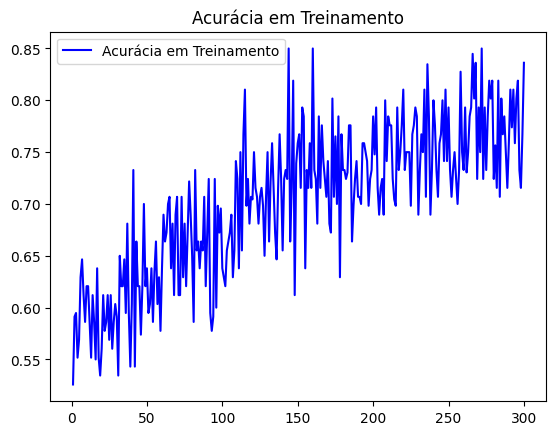

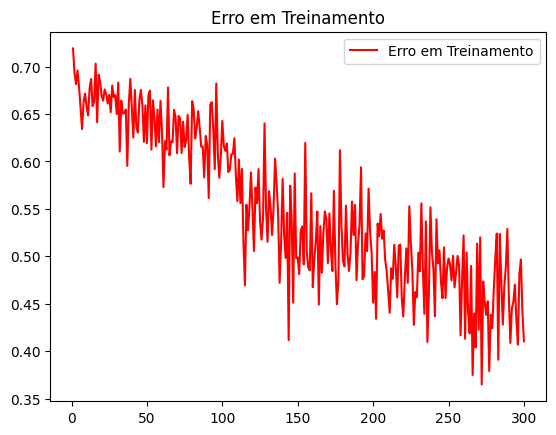

In [269]:
# Plot
plt.figure()
plt.plot(epochs, acc, '-', label = 'Acurácia em Treinamento', color = 'blue')
plt.title('Acurácia em Treinamento')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, '-', label = 'Erro em Treinamento', color = 'red')
plt.title('Erro em Treinamento')
plt.legend()
plt.show()


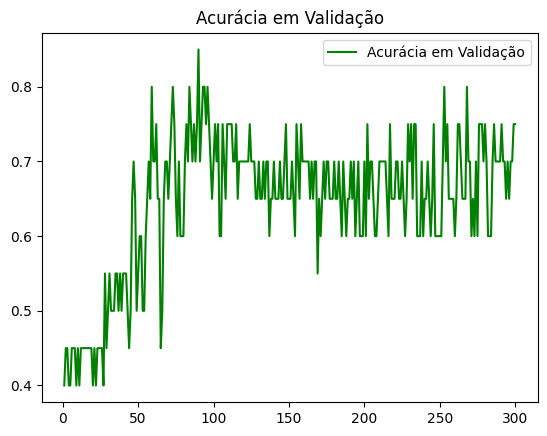

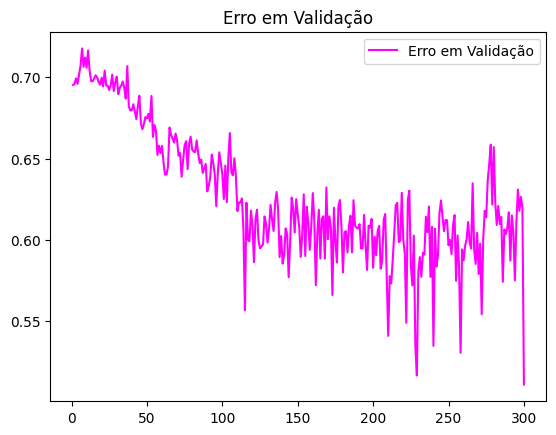

In [251]:
# Plot
plt.figure()
plt.plot(epochs, val_acc, '-', label = 'Acurácia em Validação', color = 'green')
plt.title('Acurácia em Validação')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, val_loss, '-', label = 'Erro em Validação', color = 'magenta')
plt.title('Erro em Validação')
plt.legend()
plt.show()

In [252]:
# Vamos obter os labels dos dados de teste
labels_teste = gen_teste.classes

In [253]:
# Precisamos dos labels para o plot da matriz de confusão
labels_teste.shape

(21,)

In [254]:
# Imprimimos a etiqueta (label) associada a cada classe
gen_teste.class_indices

{'Normal': 0, 'Tuberculose': 1}

In [255]:
# Fazemos as previsões
previsoes = modelo_dsa.predict(gen_teste, verbose = 1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step 


In [256]:
# Shape das previsões
#previsoes.shape
previsoes_classes = np.argmax(previsoes, axis=1)

## Interpretando a Matriz de Confusão

In [257]:
# Função para a Matriz de Confusão
def plot_confusion_matrix(cm, 
                          classes,
                          normalize = False,
                          title = 'Matriz de Confusão',
                          cmap = plt.cm.YlOrRd):

    # Se normalize = True, obtemos a matriz de confusão com dados normalizados
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    # Mostramos a Matriz de Confusão
    print(cm)

    # Plot
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Plot do texto
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label Verdadeiro')
    plt.xlabel('Label Previsto')
    plt.tight_layout()

In [258]:
# A função argmax() retorna o índice do valor máximo em uma linha
matriz_conf = confusion_matrix(labels_teste, previsoes_classes)

In [259]:
print(f"Tamanho de labels_teste: {len(labels_teste)}")
print(f"Tamanho de previsoes: {len(previsoes)}")

Tamanho de labels_teste: 21
Tamanho de previsoes: 21


In [260]:
# Labels dos dados de teste
gen_teste.class_indices

{'Normal': 0, 'Tuberculose': 1}

In [261]:
# Definimos os rótulos dos labels da classe. Eles precisam corresponder a ordem mostrada acima.
matriz_conf_plot_labels = ['Normal', 'Tuberculose']

Matriz de Confusão Sem Normalização
[[10  2]
 [ 2  7]]


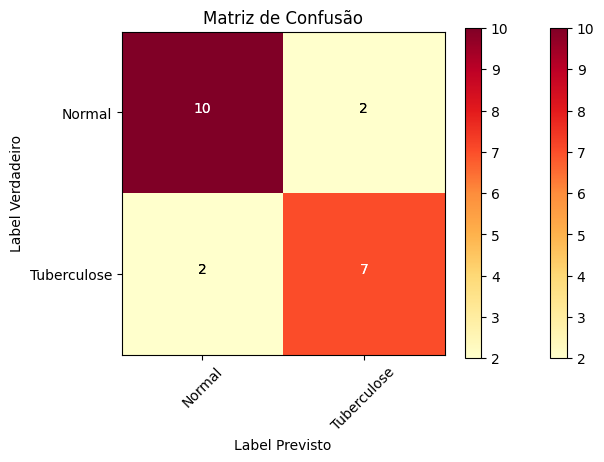

In [263]:
# E então criamos o plot
plot_confusion_matrix(matriz_conf, matriz_conf_plot_labels, title = 'Matriz de Confusão')
plt.show()

In [264]:
# Geramos a sequência na qual o gerador processou as imagens de teste
imagens_teste = gen_teste.filenames

In [265]:
imagens_teste

['Normal/MCUCXR_0002_0.png',
 'Normal/MCUCXR_0013_0.png',
 'Normal/MCUCXR_0016_0.png',
 'Normal/MCUCXR_0020_0.png',
 'Normal/MCUCXR_0022_0.png',
 'Normal/MCUCXR_0028_0.png',
 'Normal/MCUCXR_0040_0.png',
 'Normal/MCUCXR_0044_0.png',
 'Normal/MCUCXR_0048_0.png',
 'Normal/MCUCXR_0068_0.png',
 'Normal/MCUCXR_0075_0.png',
 'Normal/MCUCXR_0091_0.png',
 'Tuberculose/MCUCXR_0113_1.png',
 'Tuberculose/MCUCXR_0126_1.png',
 'Tuberculose/MCUCXR_0166_1.png',
 'Tuberculose/MCUCXR_0173_1.png',
 'Tuberculose/MCUCXR_0213_1.png',
 'Tuberculose/MCUCXR_0255_1.png',
 'Tuberculose/MCUCXR_0258_1.png',
 'Tuberculose/MCUCXR_0289_1.png',
 'Tuberculose/MCUCXR_0390_1.png']

In [266]:
# Obtemos os rótulos verdadeiros
y_true = gen_teste.classes

In [267]:
# Obtemos os rótulos previstos
y_pred = previsoes.argmax(axis=1)

## Relatório de Classificação

In [268]:
# Gera o relatório de classificação
report = classification_report(y_true, y_pred, target_names = matriz_conf_plot_labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.83      0.83      0.83        12
 Tuberculose       0.78      0.78      0.78         9

    accuracy                           0.81        21
   macro avg       0.81      0.81      0.81        21
weighted avg       0.81      0.81      0.81        21



- Recall = Dada uma classe, o classificador será capaz de detectá-la?

- Precision = Dada uma previsão de classe, qual a probabilidade de estar correta?

- F1 Score = A média harmônica de Recall e Precision. Essencialmente, ele pune valores extremos.

F1 Score é maior para a classe Normal, indicando que o modelo tende a prever melhor essa categoria, que a categoria Tuberculose. 

Mas no geral, modelo apresenta um bom equilíbrio, embora ainda tenhamos espaço para melhorias.

# Fim